In [1]:
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

import time
from PIL import Image
import numpy as np

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

Using TensorFlow backend.


## Images Preprocessing

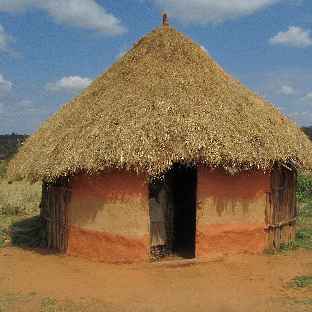

In [2]:
height = 312
width = 312

content_image = Image.open('hut.jpg')
content_image = content_image.resize((height,width))
content_image

#^Image for the base template

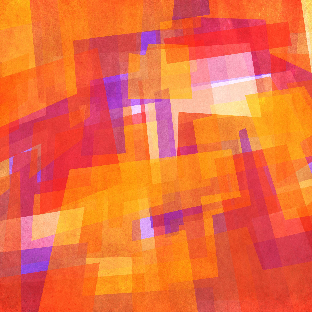

In [3]:
style_image = Image.open('texture.jpg')
style_image = style_image.resize((height,width))
style_image
#^ Image to give the style template

In [4]:
content_array = np.asarray(content_image, dtype='float32')
content_array.shape
#^Convert Image to numerical data

(312, 312, 3)

In [5]:
content_array = np.expand_dims(content_array, axis=0)
content_array.shape
#^Incresing one dimension dimension

(1, 312, 312, 3)

In [6]:
style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
style_array.shape
#^Converting style image to numerical data then adding one feature similar to content image

(1, 312, 312, 3)

In [7]:
content_array[:,:,:,0] -= 103.939 # mean of R component
content_array[:,:,:,1] -= 116.779 # mean of G component
content_array[:,:,:,2] -= 123.68  # mean of blue component
content_array = content_array[:,:,:,::-1] 
#^Subtracting RGB mean

In [8]:
style_array[:,:,:,0] -= 103.939
style_array[:,:,:,1] -= 116.779
style_array[:,:,:,2] -= 123.68
style_array = style_array[:,:,:,::-1]
#^ Reversing the order of RGB as BGR

## VGG 16 model using imagenet predefined model's weights

In [9]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1,height,width,3))
#^ Preparing imgaes for VGG 16

In [10]:
input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)

In [11]:
input_tensor

<tf.Tensor 'concat:0' shape=(3, 312, 312, 3) dtype=float32>

In [12]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

In [13]:
model.summary()
#^ Outputting model's layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers
#^ Descriptoin of layers (every block has been divided into CNNs and a final max pooling layer)

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 312, 312, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 312, 312, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 156, 156, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 156, 156, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 156, 156, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 78, 78, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 78, 78, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 78, 78, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 78, 78, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 39, 39, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 39, 39, 512) dtype=float32>,
 'block4_co

In [15]:
layers['block2_conv2'][0,:,:,:]

<tf.Tensor 'strided_slice:0' shape=(156, 156, 128) dtype=float32>

In [16]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0
#^ Using 3 hyperparameters for losses of content (loss in base image), style(loss in style image) and variation loss

In [17]:
loss = backend.variable(0.)
#^ Initialising loss

### Content Loss

In [18]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features, combination_features)

In [19]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
#^ defining gram matrix

## Style Loss

In [20]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2','block3_conv3', 'block4_conv3','block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The Total Variation Loss

In [21]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

### Loss Optimization

In [22]:
grads = backend.gradients(loss, combination_image)

In [23]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [24]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

epochs = 10

for i in range(epochs):
    print('Starting epoch', i, end = "; ")
    s_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.grads, maxfun = 20)
    print('Current loss value:', min_val)
    f_time = time.time()
    print('epoch %d completed in %ds' % (i, f_time - s_time))

Starting epoch 0; Current loss value: 1.85828e+11
epoch 0 completed in 45s
Starting epoch 1; Current loss value: 3.43782e+10
epoch 1 completed in 38s
Starting epoch 2; Current loss value: 1.8313e+10
epoch 2 completed in 37s
Starting epoch 3; Current loss value: 1.339e+10
epoch 3 completed in 41s
Starting epoch 4; Current loss value: 1.167e+10
epoch 4 completed in 41s
Starting epoch 5; Current loss value: 1.04699e+10
epoch 5 completed in 40s
Starting epoch 6; Current loss value: 9.92346e+09
epoch 6 completed in 41s
Starting epoch 7; Current loss value: 9.54469e+09
epoch 7 completed in 40s
Starting epoch 8; Current loss value: 9.26624e+09
epoch 8 completed in 41s
Starting epoch 9; Current loss value: 9.07325e+09
epoch 9 completed in 43s


## Output

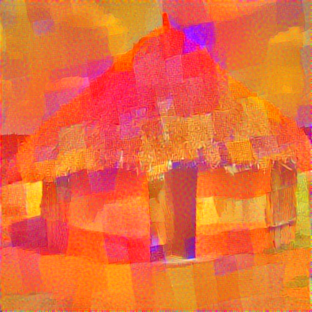

In [25]:
x = x.reshape((height, width, 3))    # Removing the added 4th feature
x = x[:, :, ::-1]                    # BGR to RGB
x[:, :, 0] += 103.939                # Mean of Red component
x[:, :, 1] += 116.779                # Mean of Green component
x[:, :, 2] += 123.68                 # Mean of Blue component
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)
#^ Generating image from the generated tensors